
> The STL-10 dataset is an image recognition dataset for developing unsupervised feature learning, deep learning, self-taught learning algorithms. It is inspired by the CIFAR-10 dataset but with some modifications. In particular, each class has fewer labeled training examples than in CIFAR-10, but a very large set of unlabeled examples is provided to learn image models prior to supervised training. The primary challenge is to make use of the unlabeled data (which comes from a similar but different distribution from the labeled data) to build a useful prior. We also expect that the higher resolution of this dataset (96x96) will make it a challenging benchmark for developing more scalable unsupervised learning methods.


The STL-10 dataset is interesting as it basically provides you two ways of solving it: 
- Use a pretrained network
- Learn the image features, for example using a autoencoder to learn what features are important

In this notebook I will provide a basic example of using a pretrained network


In [4]:
import utils.plot_utils 

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms


In [5]:
transform=torchvision.transforms.Compose([
                           torchvision.transforms.ToTensor(),
                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

train_dataset = torchvision.datasets.STL10('./data', split='train', transform=transform, download=True)
test_dataset = torchvision.datasets.STL10('./data', split='test', transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(train_dataset)
test_loader = torch.utils.data.DataLoader(test_dataset)


Files already downloaded and verified


In [55]:
def train(model, device, train_loader, optimizer, epoch, log_every=300):
    model.train()
    losses = list()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_every == 0:
            losses.append(loss.item())
    return losses

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.mse_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [56]:

import torchvision.models as models

def get_pretrained_network():
    resnet = models.resnet18(pretrained=True)
    modules = list(resnet.children())[:-1] # delete the last fc layer and spatial pooling layer
    # We use a smaller image size, so replace the avg pool 
    modules[-1] = torch.nn.AvgPool2d(kernel_size=3, stride=1, padding=0) 
    resnet = nn.Sequential(*modules)
    ### Now set requires_grad to false
    for param in resnet.parameters():
        param.requires_grad = False
    return resnet

class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.pretrained = get_pretrained_network()
        self.fc = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pretrained(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc(x))
        return F.softmax(x, dim=1)
    

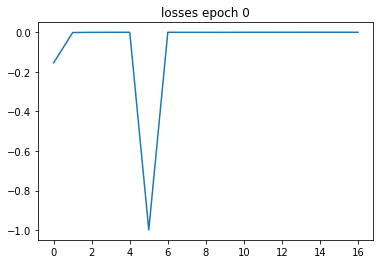

RuntimeError: Expected object of type torch.FloatTensor but found type torch.LongTensor for argument #2 'target'

In [57]:
BATCH_SIZE=64
TEST_BATCH_SIZE=64
EPOCHS=10
LEARNING_RATE=0.01

model = Network().to(device)
optimizer = optim.Adam(model.parameters()) # Feel free to use a different optimizer

for epoch in range(EPOCHS):
    losses = train(model, device, train_loader, optimizer, epoch)
    utils.plot_utils.plot_loss(losses, epoch)
    test(model, device, test_loader)


In [ ]:
for batch_idx, (data, target) in enumerate(train_loader):
    data, target = data.to(device), target.to(device)
    output = resnet18(data)


In [17]:
resnet18.fc.out_features = 10


In [49]:
result = resnet(data)


In [50]:
result.shape

torch.Size([1, 512, 1, 1])